In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

#ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


# from imblearn.over_sampling import SMOTE


In [ ]:
data = pd.read_csv('credit_card_fraud.csv')  

print(data.head())

   TransactionID             TransactionDate   Amount  MerchantID  \
0              1  2024-04-03 14:15:35.462794  4189.27         688   
1              2  2024-03-19 13:20:35.462824  2659.71         109   
2              3  2024-01-08 10:08:35.462834   784.00         394   
3              4  2024-04-13 23:50:35.462850  3514.40         944   
4              5  2024-07-12 18:51:35.462858   369.07         475   

  TransactionType      Location  IsFraud  
0          refund   San Antonio        0  
1          refund        Dallas        0  
2        purchase      New York        0  
3        purchase  Philadelphia        0  
4        purchase       Phoenix        0  


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB
None


In [ ]:
#Null value check and remove duplicates
print(data.isnull().sum())
data = data.drop_duplicates()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64


In [5]:

print(data.describe())

       TransactionID         Amount     MerchantID        IsFraud
count  100000.000000  100000.000000  100000.000000  100000.000000
mean    50000.500000    2497.092666     501.676070       0.010000
std     28867.657797    1442.415999     288.715868       0.099499
min         1.000000       1.050000       1.000000       0.000000
25%     25000.750000    1247.955000     252.000000       0.000000
50%     50000.500000    2496.500000     503.000000       0.000000
75%     75000.250000    3743.592500     753.000000       0.000000
max    100000.000000    4999.770000    1000.000000       1.000000


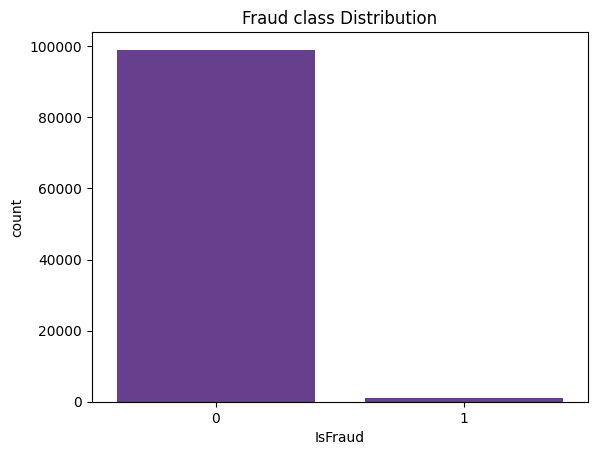

In [ ]:
#Likelyhood of fraud
sns.countplot(x='IsFraud', data=data, color='rebeccapurple')
plt.title('Fraud class Distribution')
plt.show()

In [7]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

data['TransactionHour'] = data['TransactionDate'].dt.hour
data['TransactionDay'] = data['TransactionDate'].dt.day 
data['TransactionMonth'] = data['TransactionDate'].dt.month 

data = data.drop(columns=['TransactionDate'])



In [8]:
print(data.head())

   TransactionID   Amount  MerchantID TransactionType      Location  IsFraud  \
0              1  4189.27         688          refund   San Antonio        0   
1              2  2659.71         109          refund        Dallas        0   
2              3   784.00         394        purchase      New York        0   
3              4  3514.40         944        purchase  Philadelphia        0   
4              5   369.07         475        purchase       Phoenix        0   

   TransactionHour  TransactionDay  TransactionMonth  
0               14               3                 4  
1               13              19                 3  
2               10               8                 1  
3               23              13                 4  
4               18              12                 7  


In [9]:
label_encoder_type = LabelEncoder()
label_encoder_location = LabelEncoder()

data['TransactionType'] = label_encoder_type.fit_transform(data['TransactionType'])
data['Location'] = label_encoder_location.fit_transform(data['Location'])

transaction_type_mapping = dict(zip(label_encoder_type.classes_, range(len(label_encoder_type.classes_))))
location_mapping = dict(zip(label_encoder_location.classes_, range(len(label_encoder_location.classes_))))

transaction_type_inverse_mapping = {v: k for k, v in transaction_type_mapping.items()}
location_inverse_mapping = {v: k for k, v in location_mapping.items()}

In [39]:
print(data.head())

   TransactionID   Amount  MerchantID  TransactionType  Location  IsFraud  \
0              1  4189.27         688                1         7        0   
1              2  2659.71         109                1         1        0   
2              3   784.00         394                0         4        0   
3              4  3514.40         944                0         5        0   
4              5   369.07         475                0         6        0   

   TransactionHour  TransactionDay  TransactionMonth Location_name  \
0               14               3                 4   San Antonio   
1               13              19                 3        Dallas   
2               10               8                 1      New York   
3               23              13                 4  Philadelphia   
4               18              12                 7       Phoenix   

  TransactionType_name FraudStatus  
0               refund   Non-Fraud  
1               refund   Non-Fraud  
2    

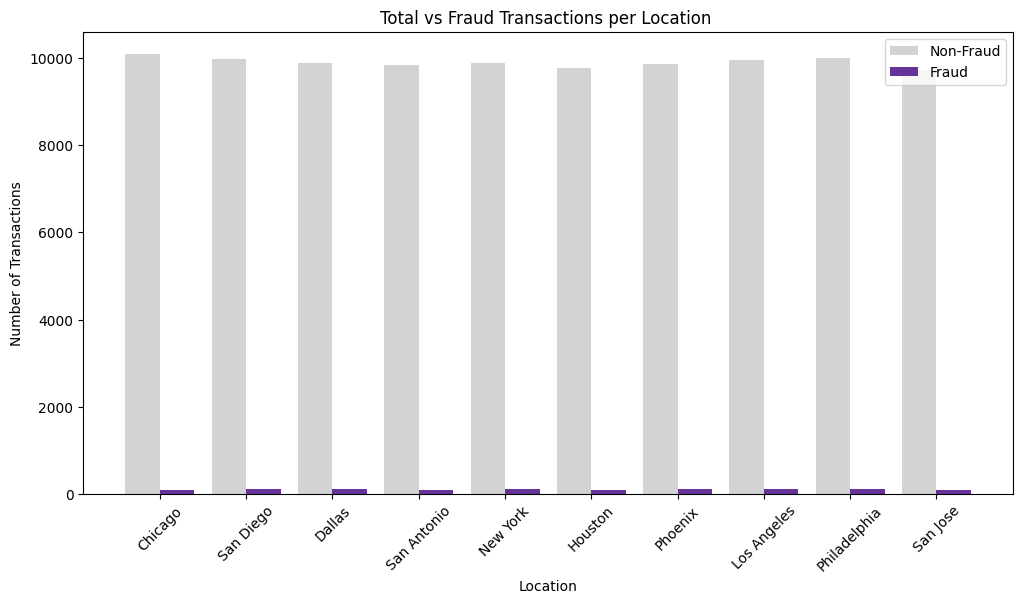

In [11]:
# Mapping numeric codes back to names
data['Location_name'] = data['Location'].map(location_inverse_mapping)
data['TransactionType_name'] = data['TransactionType'].map(transaction_type_inverse_mapping)


total_per_location = data.groupby('Location_name')['IsFraud'].count()
fraud_per_location = data.groupby('Location_name')['IsFraud'].sum()
nonfraud_per_location = total_per_location - fraud_per_location

sorted_index = total_per_location.sort_values(ascending=False).index
total_per_location = total_per_location[sorted_index]

x = np.arange(len(sorted_index))

plt.figure(figsize=(12,6))
plt.bar(x - 0.2, nonfraud_per_location, width=0.4, label='Non-Fraud', color='lightgray')
plt.bar(x + 0.2, fraud_per_location, width=0.4, label='Fraud', color='rebeccapurple')

plt.xticks(x, sorted_index, rotation=45)
plt.ylabel('Number of Transactions')
plt.xlabel('Location')
plt.title('Total vs Fraud Transactions per Location ')
plt.legend()
plt.show()


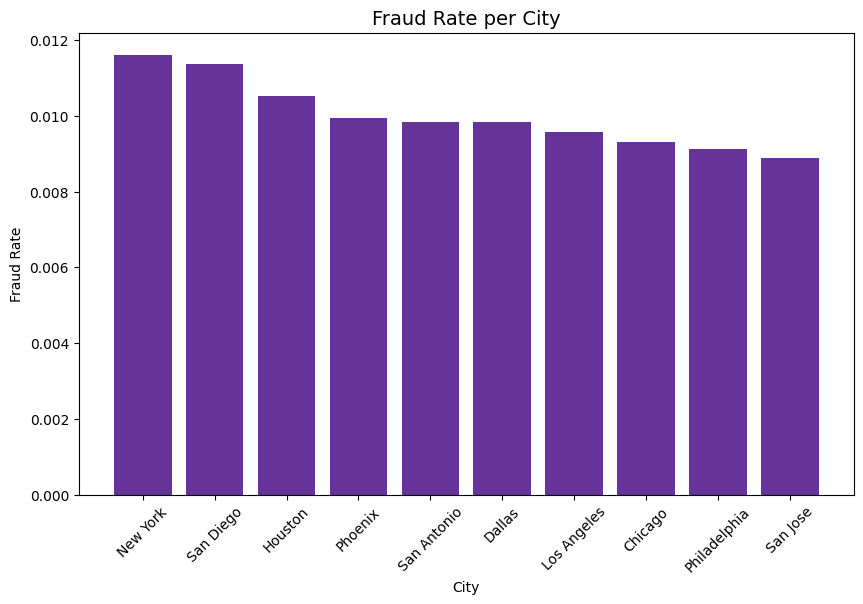

In [37]:
total_per_location = data.groupby('Location_name')['IsFraud'].count()
fraud_per_location = data.groupby('Location_name')['IsFraud'].sum()

fraud_rate = (fraud_per_location / total_per_location).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(fraud_rate.index, fraud_rate.values, color='rebeccapurple')
plt.title('Fraud Rate per City', fontsize=14)
plt.ylabel('Fraud Rate')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.show()

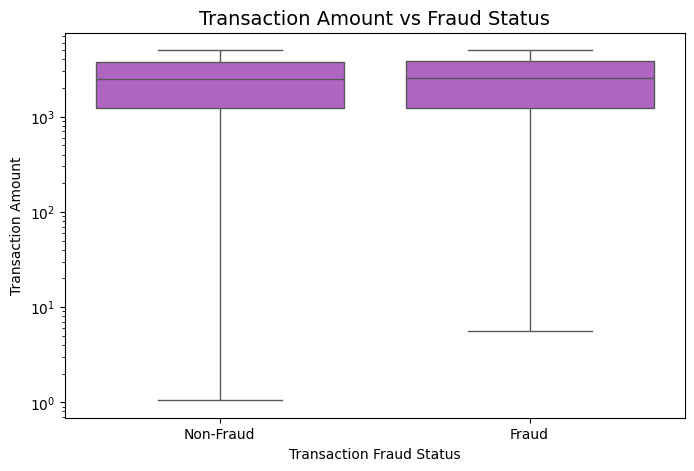

In [38]:
data['FraudStatus'] = data['IsFraud'].map({0: 'Non-Fraud', 1: 'Fraud'})

plt.figure(figsize=(8,5))
sns.boxplot(x='FraudStatus', y='Amount', data=data, color='mediumorchid')  
plt.title('Transaction Amount vs Fraud Status', fontsize=14)
plt.xlabel('Transaction Fraud Status')
plt.ylabel('Transaction Amount')
plt.yscale('log') 
plt.show()



In [14]:
summary_stats = data.groupby('FraudStatus')['Amount'].describe()

print(summary_stats)

               count        mean          std   min        25%      50%  \
FraudStatus                                                               
Fraud         1000.0  2517.16444  1458.643653  5.56  1249.2775  2543.43   
Non-Fraud    99000.0  2496.88992  1442.257175  1.05  1247.9550  2495.61   

                  75%      max  
FraudStatus                     
Fraud        3813.850  4985.88  
Non-Fraud    3742.855  4999.77  


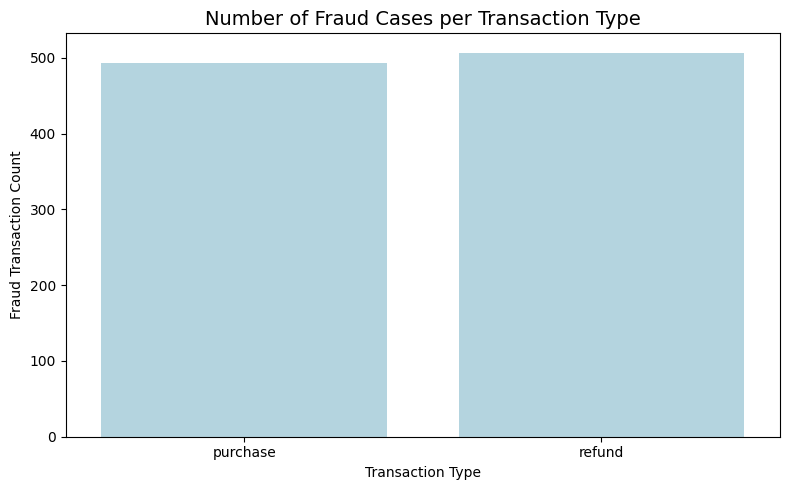

In [15]:
data['TransactionType_name'] = data['TransactionType'].map(transaction_type_inverse_mapping)
fraud_data = data[data['IsFraud'] == 1]

plt.figure(figsize=(8,5))
sns.countplot(x='TransactionType_name', data=fraud_data, color='lightblue')
plt.title('Number of Fraud Cases per Transaction Type', fontsize=14)
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Transaction Count') 
plt.tight_layout()
plt.show()

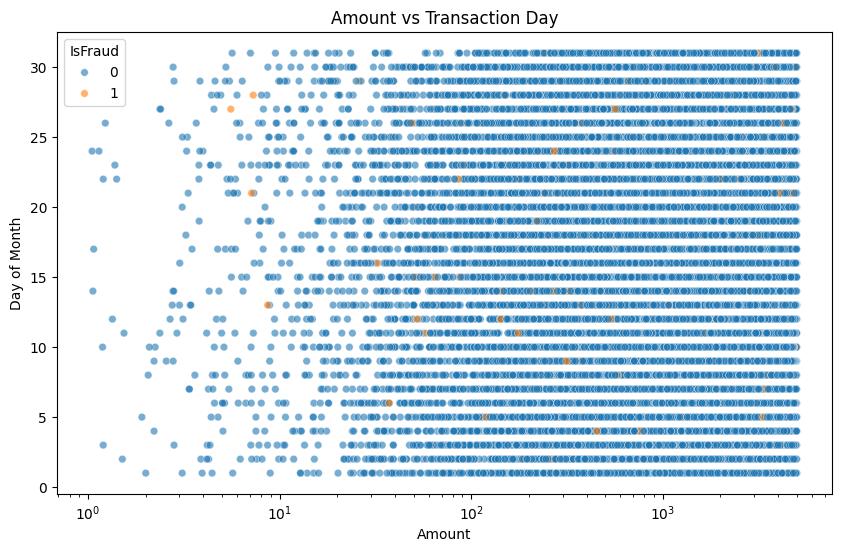

In [16]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='Amount', y='TransactionDay', hue='IsFraud', data=data, s=30, alpha=0.6)
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')
plt.title('Amount vs Transaction Day')
plt.xscale('log') 
plt.xlabel('Amount')
plt.ylabel('Day of Month')
plt.show()


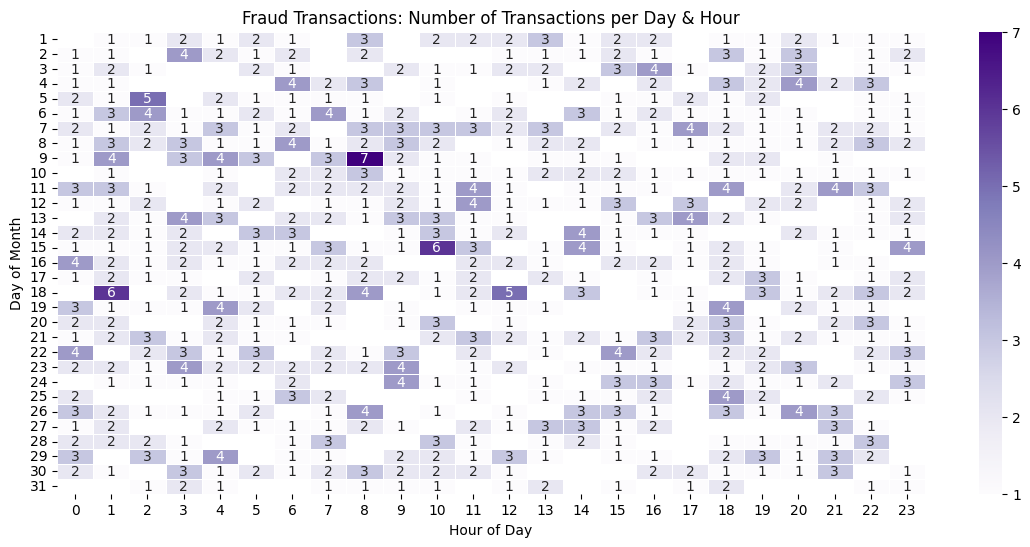

In [17]:
#Nr of Total Transactions
fraud_heat = data[data['IsFraud']==1].pivot_table(index='TransactionDay',columns='TransactionHour',values='Amount',aggfunc='count')

plt.figure(figsize=(14,6))
sns.heatmap(fraud_heat, cmap='Purples', linewidths=0.5, annot=True, fmt='g')
plt.title('Fraud Transactions: Number of Transactions per Day & Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Month')
plt.show()


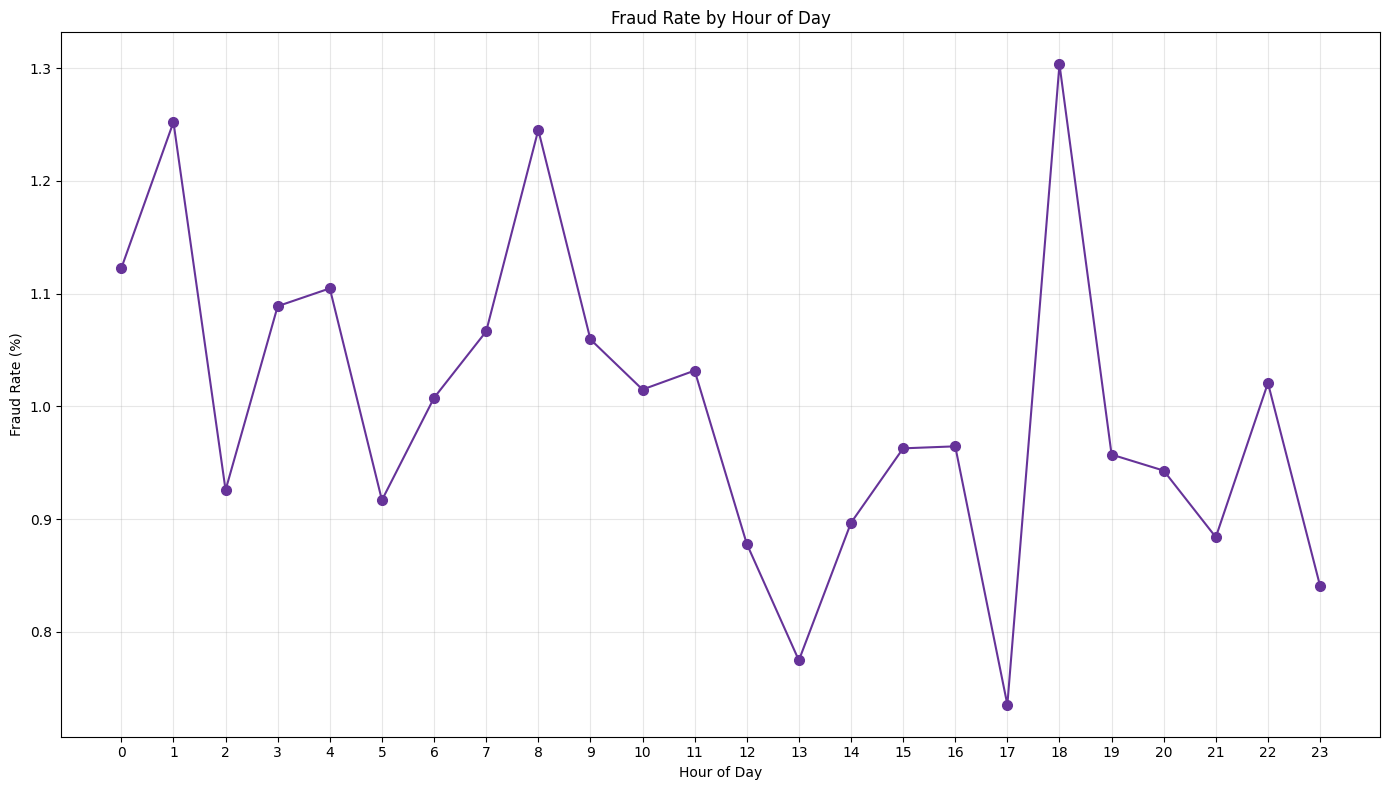

In [18]:
#Hourly Rate

hourly_fraud = data.groupby('TransactionHour').agg({'IsFraud': ['sum', 'count']}).reset_index()
hourly_fraud.columns = ['Hour', 'FraudCount', 'TotalCount']
hourly_fraud['FraudRate'] = (hourly_fraud['FraudCount'] / hourly_fraud['TotalCount']) * 100

plt.figure(figsize=(14, 8))
plt.plot(hourly_fraud['Hour'], hourly_fraud['FraudRate'], marker='o', markersize=7, color='rebeccapurple')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

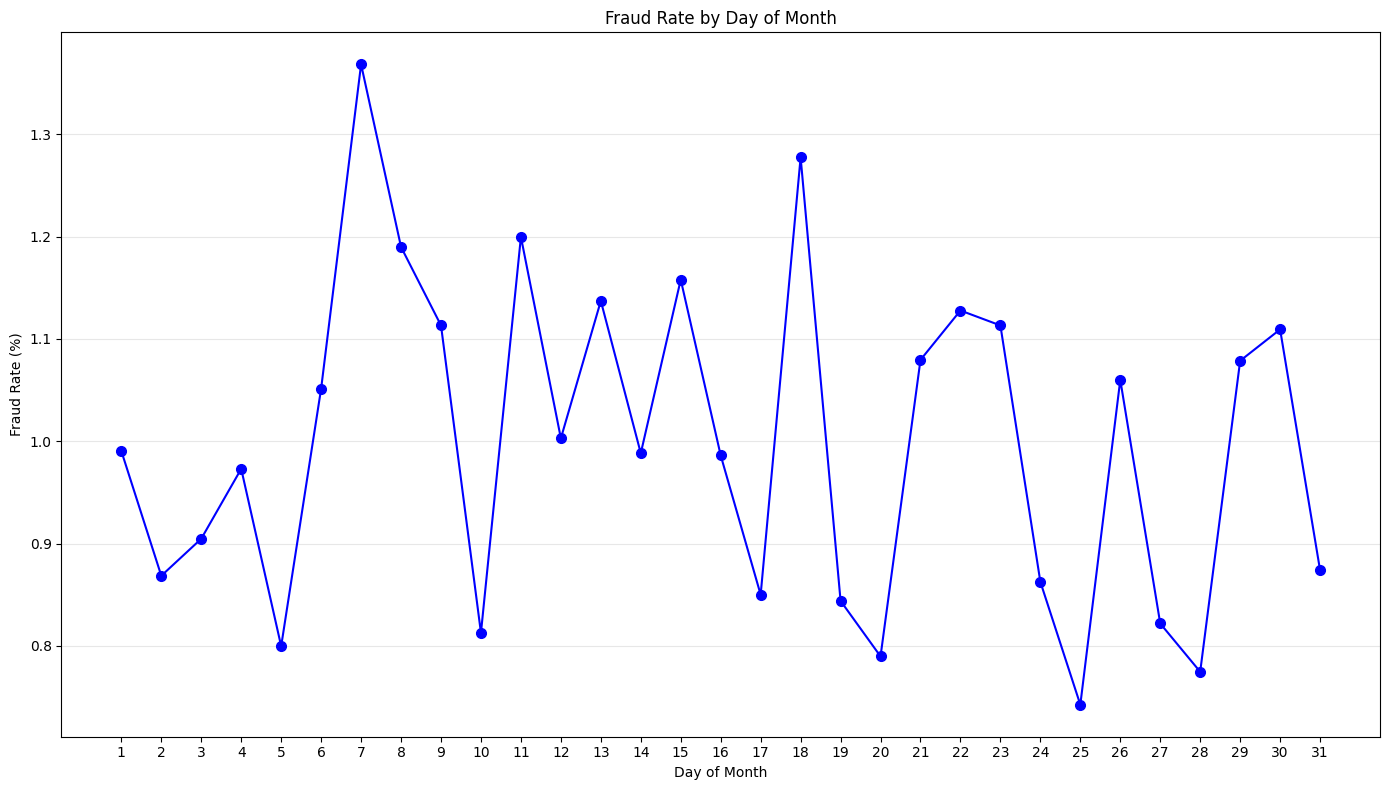

In [19]:
#Daily Rate

daily_fraud = data.groupby('TransactionDay')['IsFraud'].agg(['sum', 'count']).reset_index()
daily_fraud.columns = ['Day', 'FraudCount', 'TotalCount']
daily_fraud['FraudRate'] = (daily_fraud['FraudCount'] / daily_fraud['TotalCount']) * 100

plt.figure(figsize=(14, 8))
plt.plot(daily_fraud['Day'], daily_fraud['FraudRate'], marker='o', markersize=7, color='blue')
plt.title('Fraud Rate by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Fraud Rate (%)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(1, 32))
plt.tight_layout()
plt.show()

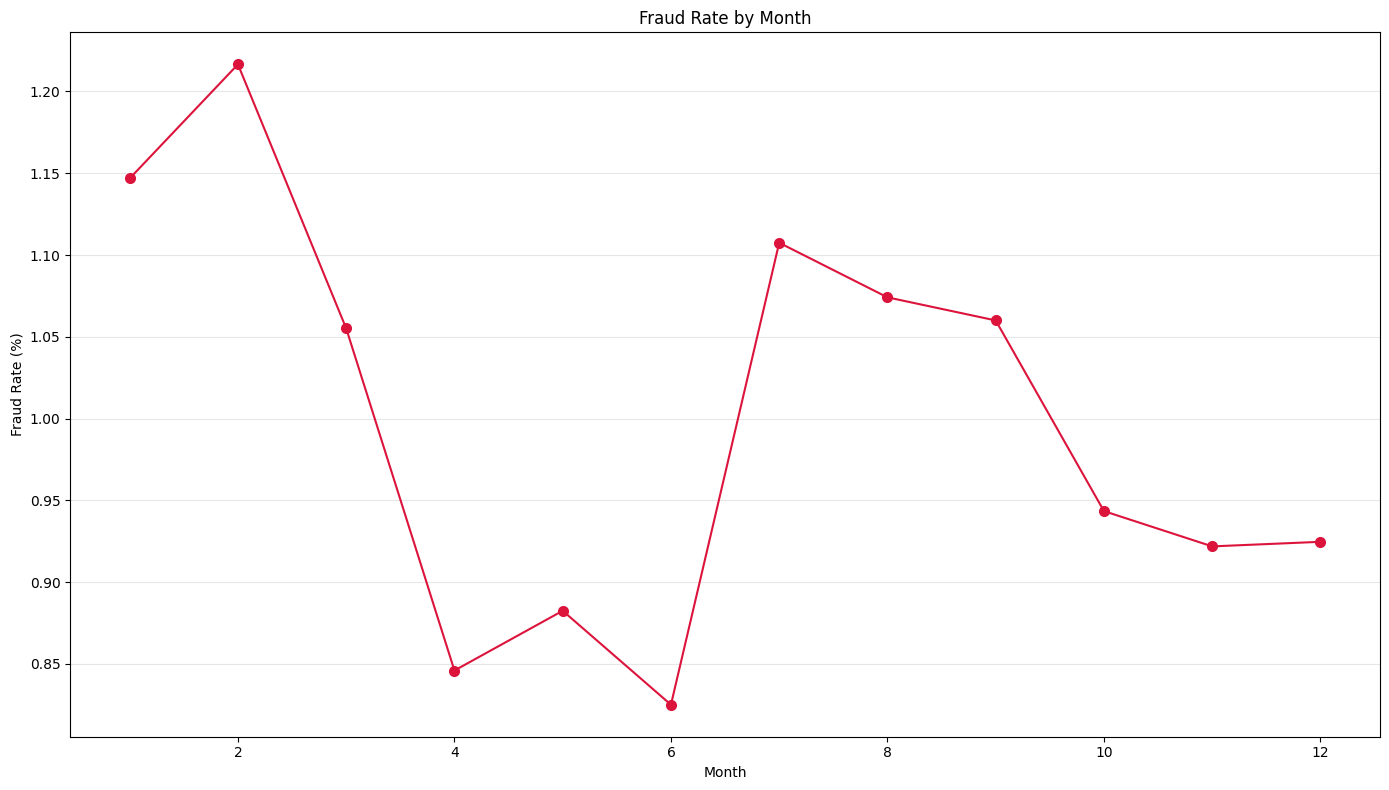

In [20]:
#Monthly Rate
plt.figure(figsize=(14, 8))
monthly_fraud = data.groupby('TransactionMonth')['IsFraud'].agg(['sum', 'count']).reset_index()
monthly_fraud.columns = ['Month', 'FraudCount', 'TotalCount']
monthly_fraud['FraudRate'] = (monthly_fraud['FraudCount'] / monthly_fraud['TotalCount']) * 100

plt.plot(monthly_fraud['Month'], monthly_fraud['FraudRate'], marker='o', markersize=7, color='crimson')
plt.title('Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Fraud Rate (%)')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

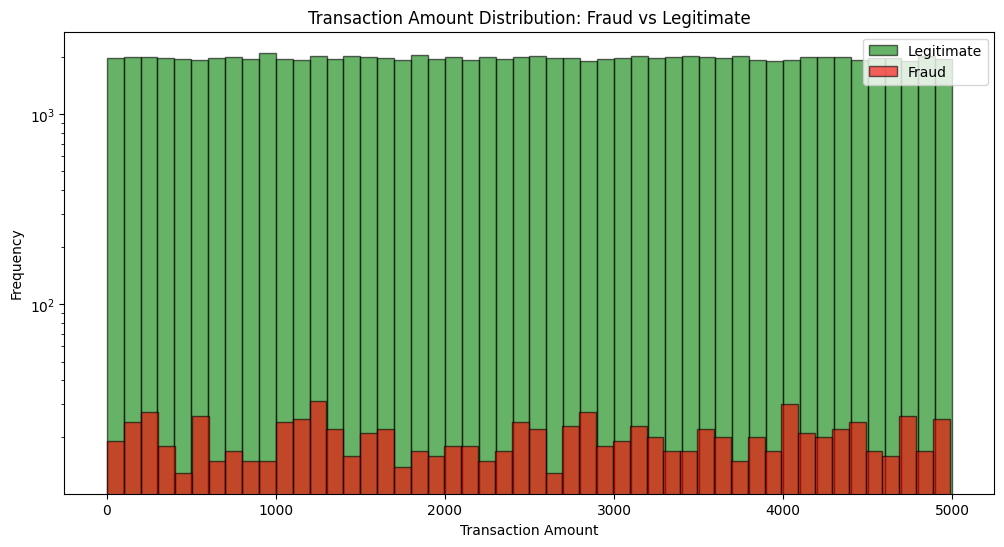

In [21]:
fraud_amounts = data[data['IsFraud'] == 1]['Amount']
legit_amounts = data[data['IsFraud'] == 0]['Amount'] 

plt.figure(figsize=(12, 6))
plt.hist(legit_amounts,  bins=50,  alpha=0.6, label='Legitimate', color='green', edgecolor='black')
plt.hist(fraud_amounts, bins=50, alpha=0.6, label='Fraud', color='red', edgecolor='black')
plt.title("Transaction Amount Distribution: Fraud vs Legitimate")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.yscale('log')  
plt.legend()
plt.show()


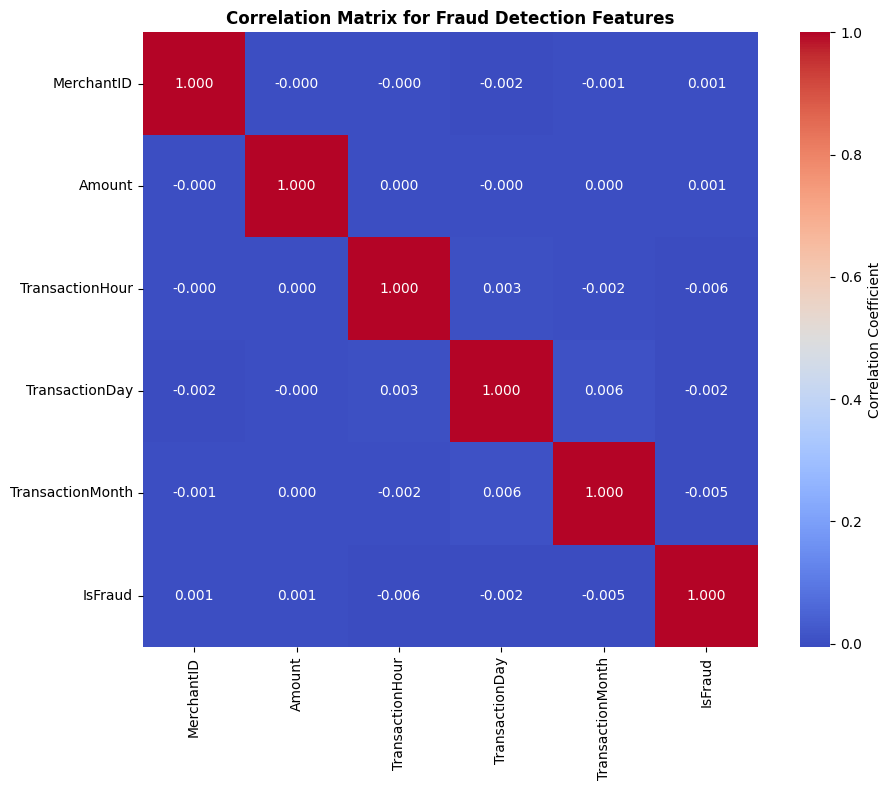

In [40]:
numerical_cols = ['MerchantID','Amount', 'TransactionHour', 'TransactionDay', 'TransactionMonth', 'IsFraud']

correlation_matrix = data[numerical_cols].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', square=True, cbar_kws={'label': 'Correlation Coefficient'})  
plt.title('Correlation Matrix for Fraud Detection Features' ,fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()